# Text Generation with Recurrent Neural Networks (RNNs)

In this assignment, you'll build upon your understanding of RNNs and Keras to develop a word-level text generation model.  Your goal is to train a model that learns the stylistic nuances of a chosen corpus and generates new, original text segments that echo the source material's essence.

**Datasets**

We've provided several intriguing text corpora to get you started:

*   Mark Twain
*   Charles Dickens
*   William Shakespeare

**Feel free to explore!**  If you have a particular passion for another author, genre, or a specific text, you're encouraged to use your own dataset of raw text.

In [1]:
# Check if we have a GPU available
'''

import tensorflow as tf
if tf.test.gpu_device_name():
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))
else:
    print("No GPU available. If you're on Colab, go to Runtime > Change runtime and select a GPU hardware accelerator.")

'''

'\n\nimport tensorflow as tf\nif tf.test.gpu_device_name():\n    print(\'Default GPU Device: {}\'.format(tf.test.gpu_device_name()))\nelse:\n    print("No GPU available. If you\'re on Colab, go to Runtime > Change runtime and select a GPU hardware accelerator.")\n\n'

In [2]:
def download_file(url, file_path):
    import requests
    r = requests.get(url)
    with open(file_path, 'wb') as f:
        f.write(r.content)

def load_dataset(file_path, fraction=1.0):
    with open(file_path, 'r', encoding='utf-8') as f:
        raw_text = f.read()
    return raw_text[:int(fraction * len(raw_text))]

dataset = 'shakespeare.txt' # Other options are mark_twain.txt, charles_dickens.txt

download_file(f'https://github.com/UofT-DSI/deep_learning/raw/main/assignments/downloaded_books/' + dataset, dataset)

# Load chosen dataset. NOTE: If Colab is running out of memory, change the `fraction` parameter to a value between 0 and 1 to load less data.
text = load_dataset(dataset, fraction=0.1)

# 1. Data Preparation (Complete or Incomplete)

Before we can begin training an RNN model, we need to prepare the dataset. This involves cleaning the text, tokenizing words, and creating sequences the model can be trained on.

## 1.1 Data Exploration

Print the first 1000 characters of the dataset. Report the dataset's size and the number of unique characters it contains.

In [3]:
dataset = 'downloaded_books/shakespeare.txt'

text = load_dataset(dataset, fraction=0.1)

In [4]:

unique_characters = len(set(text))
print(f"Number of unique characters: {unique_characters}")

print ("Size in characters:", len(text))


Number of unique characters: 131
Size in characters: 935886


In [5]:
# Your code here

text[:1000].split(" ")


['The',
 'Project',
 'Gutenberg',
 'EBook',
 'of',
 'Hamlet,',
 'by',
 'William',
 'Shakespeare\n\nThis',
 'eBook',
 'is',
 'for',
 'the',
 'use',
 'of',
 'anyone',
 'anywhere',
 'at',
 'no',
 'cost',
 'and',
 'with\nalmost',
 'no',
 'restrictions',
 'whatsoever.',
 '',
 'You',
 'may',
 'copy',
 'it,',
 'give',
 'it',
 'away',
 'or\nre-use',
 'it',
 'under',
 'the',
 'terms',
 'of',
 'the',
 'Project',
 'Gutenberg',
 'License',
 'included\nwith',
 'this',
 'eBook',
 'or',
 'online',
 'at',
 'www.gutenberg.org\n\n\nTitle:',
 'Hamlet\n\nAuthor:',
 'William',
 'Shakespeare\n\nEditor:',
 'Charles',
 'Kean\n\nRelease',
 'Date:',
 'January',
 '10,',
 '2009',
 '[EBook',
 '#27761]\n\nLanguage:',
 'English\n\nCharacter',
 'set',
 'encoding:',
 'UTF-8\n\n***',
 'START',
 'OF',
 'THIS',
 'PROJECT',
 'GUTENBERG',
 'EBOOK',
 'HAMLET',
 '***\n\n\n\n\nProduced',
 'by',
 'David',
 'Starner,',
 'Curtis',
 'Weyant',
 'and',
 'the',
 'Online\nDistributed',
 'Proofreading',
 'Team',
 'at',
 'https://www.p

## 1.2 Text Pre-Processing

To prepare the dataset for training, we need to clean the text and create a numerical representation the model can interpret. Perform the following pre-processing steps:

*   Convert the entire text to lowercase.
*   Use the `Tokenizer` class from the `keras.preprocessing.text` module to tokenize the text. You should fit the tokenizer on the text and then convert the text to a sequence of numbers. You can use the `texts_to_sequences` method to do this.

**Note**:
* You'll need to specify an appropriate size for the vocabulary. The number of words in the list of most common words can serve as a guide - does it seem like a reasonable vocabulary size?
* Some of the words will be excluded from the vocabulary, as they don't appear often enough. It's important to provide a value for `oov_token` when creating the Tokenizer instance, so that these words can be represented as "unknown".

In [6]:
import numpy as np
from keras.preprocessing.text import Tokenizer
from sklearn.feature_extraction.text import CountVectorizer

# Your code here
VOCAB_SIZE = 10000
OOV_TOKEN = "<OOV>"
tokenizer = None

# Convert the entire text to lowercase
text_lower = text.lower()

# Create a tokenizer and fit it on the text
# max_words = 10000  # Set the maximum number of words in the vocabulary
tokenizer = Tokenizer(num_words=VOCAB_SIZE, char_level=False, oov_token=OOV_TOKEN)
tokenizer.fit_on_texts([text_lower])

sequences = tokenizer.texts_to_sequences(text_lower)
sequences_test = tokenizer.texts_to_sequences(text_lower)


# Get the number of words in the vocabulary
VOCAB_SIZE = len(tokenizer.word_index) + 1  # Add 1 for the OOV token


If everything worked, the following line should show you the first 10 words in the vocabulary:

In [7]:
try:
    print(list(tokenizer.word_index.items())[:10])
except AttributeError:
    print("Tokenizer has not been initialized. Possible issue: Complete the relevant section of the assignment to initialize it."
)


[('<OOV>', 1), ('the', 2), ('and', 3), ('of', 4), ('to', 5), ('a', 6), ('in', 7), ('i', 8), ('that', 9), ('you', 10)]


## 1.3 Sequence Generation

Now that the text has been tokenized, we need to create sequences the model can be trained on. There are two parts to this:

*   Use the `texts_to_sequences` method from the tokenizer to convert the text to a list of sequences of numbers.
*   Generate the training sequences. Each training sequence should contain `SEQ_LENGTH` token IDs from the text. The target token for each sequence should be the word that follows the sequence in the text.

In [8]:
SEQ_LENGTH = 100 # Choose an appropriate sequence length

# Convert the text to a list of sequences of numbers
sequences = tokenizer.texts_to_sequences([text_lower])[0]

# Generate the training sequences
X = []
y = []

# Your code here
# Generate training sequences
for i in range(len(sequences) - SEQ_LENGTH):
    input_sequence = sequences[i:i + SEQ_LENGTH]
    target_token = sequences[i + SEQ_LENGTH]
    X.append(input_sequence)
    y.append(target_token)

# Convert X and y to numpy arrays
X = np.array(X)
y = np.array(y)

# Print the first few training sequences
print("First few training sequences:")
for i in range(5):
    print(f"Input: {X[i]} -> Target: {y[i]}")

First few training sequences:
Input: [   2   56   54  411    4  107   28  668  172   20  411   13   16    2
  176    4  669 1643   33   43 1095    3   14  412   43 1790 1423   10
   85  333   15  124   15  163   29  531  176   15  254    2  216    4
    2   56   54  297 1248   14   20  411   29  759   33  592   54  366
  785  107 1424  668  172 2492 1644 2833 1531  564 5224  532 5225  411
 3310  989  609  533  177 2493 2254  462  874    4   20   56   54  411
  107  875   28 4086 5226 5227 5228    3    2  759  733 2255 2002   33
 1532  592] -> Target: 2256
Input: [  56   54  411    4  107   28  668  172   20  411   13   16    2  176
    4  669 1643   33   43 1095    3   14  412   43 1790 1423   10   85
  333   15  124   15  163   29  531  176   15  254    2  216    4    2
   56   54  297 1248   14   20  411   29  759   33  592   54  366  785
  107 1424  668  172 2492 1644 2833 1531  564 5224  532 5225  411 3310
  989  609  533  177 2493 2254  462  874    4   20   56   54  411  107
  875

Assuming your sequences are stored in `X` and the corresponding targets in `y`, the following line should print the first training sequence and its target:

In [9]:
if len(X) > 0 and len(y) > 0:
    print(f'Sequence: {X[0]}\nTarget: {y[0]}')
    print(f'Translated back to words: {[tokenizer.index_word[i] for i in X[0]]} -> {tokenizer.index_word[y[0]]}')
else:
    print("Training sequences have not been generated. Possible issue: Complete the relevant section of the assignment to initialize it.")


Sequence: [   2   56   54  411    4  107   28  668  172   20  411   13   16    2
  176    4  669 1643   33   43 1095    3   14  412   43 1790 1423   10
   85  333   15  124   15  163   29  531  176   15  254    2  216    4
    2   56   54  297 1248   14   20  411   29  759   33  592   54  366
  785  107 1424  668  172 2492 1644 2833 1531  564 5224  532 5225  411
 3310  989  609  533  177 2493 2254  462  874    4   20   56   54  411
  107  875   28 4086 5226 5227 5228    3    2  759  733 2255 2002   33
 1532  592]
Target: 2256
Translated back to words: ['the', 'project', 'gutenberg', 'ebook', 'of', 'hamlet', 'by', 'william', 'shakespeare', 'this', 'ebook', 'is', 'for', 'the', 'use', 'of', 'anyone', 'anywhere', 'at', 'no', 'cost', 'and', 'with', 'almost', 'no', 'restrictions', 'whatsoever', 'you', 'may', 'copy', 'it', 'give', 'it', 'away', 'or', 're', 'use', 'it', 'under', 'the', 'terms', 'of', 'the', 'project', 'gutenberg', 'license', 'included', 'with', 'this', 'ebook', 'or', 'online',

And the following code will transform y into a one-hot encoded matrix, and split everything into training and validation sets:

In [10]:
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical
import numpy as np

# Ensure that tokenizer has been initialized
if tokenizer is not None:
    # Convert X and y to numpy arrays
    X = np.array(X)
    y = np.array(y)

    # One last thing: let's drop any examples where the target is the OOV token - we don't want our model to predict that (boring!)
    if OOV_TOKEN in tokenizer.word_index:
        mask = y != tokenizer.word_index[OOV_TOKEN]
        X = X[mask]
        y = y[mask]

    # One-hot encode the target token
    y = to_categorical(y, num_classes=VOCAB_SIZE)

    # Split the data into training and validation sets
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

    print(f'X_train shape: {X_train.shape}')
    print(f'y_train shape: {y_train.shape}')
else:
    print("Tokenizer has not been initialized. Please initialize it and load the vocabulary before continuing.")


X_train shape: (122681, 100)
y_train shape: (122681, 13219)


# 2. Model Development (Complete or Incomplete)

With the dataset prepared, it's time to develop the RNN model. You'll need to define the architecture of the model, compile it, and prepare it for training.

## 2.1 Model Architecture

Define the architecture of your RNN model. You can design it however you like, but there are a few features that it's important to include:

*   An embedding layer that learns a dense representation of the input tokens. You'll need to specify the input dimension (the size of the vocabulary) and the output dimension (the size of the dense representation). Remember, you can look at the documentation [here](https://keras.io/api/layers/core_layers/embedding/).
*   At least one recurrent layer. We have learned how to use LSTM layers in class, but you can use other types of recurrent layers if you prefer. You can find the documentation [here](https://keras.io/api/layers/recurrent_layers/lstm/).
*   A dense layer with a softmax activation function. This layer will output a probability distribution over the vocabulary, so that the model can make predictions about the next token.

In [11]:
from keras.models import Sequential
from keras.layers import Embedding, LSTM, Dense, Conv1D, MaxPooling1D, Flatten


model = Sequential([

    # Your code here
    Embedding(input_dim=VOCAB_SIZE, output_dim=128, input_length=SEQ_LENGTH, trainable = True),
    LSTM(100), # return_sequences=True for sequence-to-sequence prediction
    Dense(units=VOCAB_SIZE, activation='softmax')
])

# Check if the model has layers before trying to print the summary
if len(model.layers) > 0:
    model.summary()
else:
    print("No layers have been added to the model. Please complete the assignment by adding the required layers.")

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 100, 128)          1692032   
                                                                 
 lstm (LSTM)                 (None, 100)               91600     
                                                                 
 dense (Dense)               (None, 13219)             1335119   
                                                                 
Total params: 3,118,751
Trainable params: 3,118,751
Non-trainable params: 0
_________________________________________________________________


## 2.2 Model Compilation

Compile the model with an appropriate loss function and optimizer. You might also want to track additional metrics, such as accuracy.

Give a short explanation of your choice of loss function and optimizer:

_your explanation here_

In [12]:
# Your code here
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


## 2.3 Model Training

Train the model on the training data you've prepared.

* Train your model for 5 epochs with a batch size of 128. Use the validation data for validation.
* Store the training history in a variable called `history`.

In [13]:
# Your code here

history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=5, batch_size=128)


Epoch 1/5
959/959 [==============================] - 207s 209ms/step - loss: 7.0568 - accuracy: 0.0482 - val_loss: 6.8282 - val_accuracy: 0.0594
Epoch 2/5
959/959 [==============================] - 235s 245ms/step - loss: 6.4870 - accuracy: 0.0751 - val_loss: 6.4516 - val_accuracy: 0.0847
Epoch 3/5
959/959 [==============================] - 236s 247ms/step - loss: 6.0565 - accuracy: 0.1023 - val_loss: 6.1990 - val_accuracy: 0.1054
Epoch 4/5
959/959 [==============================] - 245s 256ms/step - loss: 5.7259 - accuracy: 0.1225 - val_loss: 6.0720 - val_accuracy: 0.1148
Epoch 5/5
959/959 [==============================] - 252s 263ms/step - loss: 5.4711 - accuracy: 0.1367 - val_loss: 5.9884 - val_accuracy: 0.1213


Plot the training history to visualize the model's learning progress. Your plot should include the training and validation loss.

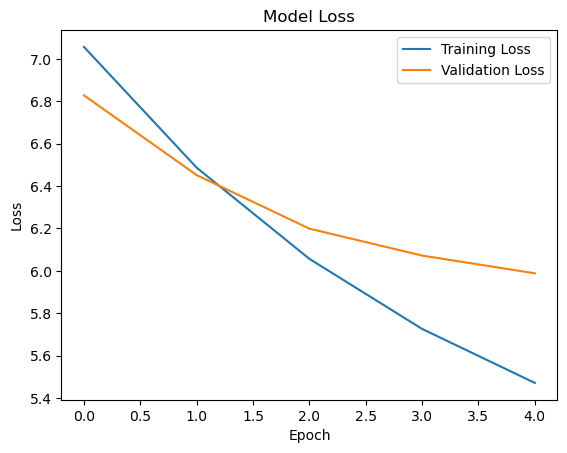

In [14]:
import matplotlib.pyplot as plt

# Your code here
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# 3. Text Generation (Complete or Incomplete)

Write a method called `generate_text` that uses the trained model to generate new text. The method should take the following parameters:

*   `model`: The trained RNN model.
*   `tokenizer`: The tokenizer used to pre-process the text data.
*   `seed_text`: The seed text the model will use to generate new text.
*   `max_sequence_len`: The maximum length of the sequence used to generate new text.

The method should return the generated text.

An overview of the text generation process you should follow:

1. Tokenize the seed text using the tokenizer we built before.
2. Pad the sequences to the same length as the training sequences - you can use the `pad_sequences` method from the `keras.preprocessing.sequence` module, which is documented [here](https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/sequence/pad_sequences).
3. Use the model to predict the next token in the sequence. Remember that the model will output a probability distribution over the vocabulary, so you'll need to use `np.argmax` to find the token with the highest probability.
4. Add the predicted token to the sequence and remove the first token.
5. Repeat steps 3-4 until you have generated the desired number of tokens.
6. Convert the generated token IDs back to words and return the combined result as a single string.

This is a challenging task, so don't hesitate to ask for help if you need it. It's okay if the generated text doesn't make much sense yet - we'll work on improving the model next.
As a bonus, you can make your method generate "gpt-style" by having it print out each word as it's generated, so you can see the text being generated in real time.

In [15]:
from keras.utils import pad_sequences


def get_predicted_word(model, sequence):
    """
    Get the predicted word from the model.
    This helper function uses a concept we haven't covered in class yet: temperature.
    In essence, a little bit of randomness in what word we predict can make the text more interesting.
    """

    # Use the model to predict the next token in the sequence
    yhat = model.predict(sequence, verbose=0)

    # Get the index of the predicted word, according to the probabilities
    yhat = np.random.choice(range(VOCAB_SIZE), p=yhat.ravel())

    return yhat

def generate_text(model, tokenizer, seed_text, max_sequence_len):
    """
    Generate new text using the trained model.
    You can use the `get_predicted_word` helper function to help you with this.
    """
    generated_text = seed_text.lower()  # Initialize with seed text (converted to lowercase)

    for _ in range(max_sequence_len):
        # Tokenize the current generated text
        sequence = tokenizer.texts_to_sequences([generated_text])[0]
        sequence = pad_sequences([sequence], maxlen=max_sequence_len, padding='pre')

        # Get the predicted word index
        predicted_index = get_predicted_word(model, sequence)

        # Convert the predicted index back to a word
        predicted_word = tokenizer.index_word.get(predicted_index, "<OOV>")

        # Append the predicted word to the generated text
        generated_text += " " + predicted_word
    
    return generated_text


In [16]:
# Test the text generation function
generated_text  = generate_text(model, tokenizer, 'hamlet', SEQ_LENGTH)

print("Generated text:", generated_text)

Generated text: hamlet ii 2 dromio and corinth saved delight i so aside but but three nimble of that once by a remainder ’ 235 elves when he tell we find the friend is better more pros what was in course the centaur to do not 90 ant it and he succeed got all my two message that solid honour i'll contrary lament nay tutor an words as calm reader’s gaze ant s to bear your mother of it mortal benefit dro s thine 15 it is that heaven but and like released thee to me and admit but willing to win cuckold


It's likely that the text generated by your model doesn't make much sense yet. This is because the model hasn't been trained for very long, and the training dataset is relatively small. 

# 4. Model Refinement (Complete or Incomplete)

In this last section, you'll work on improving your model. There are many ways to do this, but here are a few ideas to get you started:

* Use pre-trained embeddings: the code below will help you to load pre-trained embeddings through Keras. 
* Experiment with different model architectures, including the number of layers, the number of units in each layer, and the use of dropout layers.
* Train your model for longer. You can also experiment with different batch sizes.

Implement and test out at least one of these ideas. If you have other ideas for improving the model, feel free to try them out as well.

In [17]:
!wget https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
!unzip glove.6B.zip

'wget' is not recognized as an internal or external command,
operable program or batch file.
'unzip' is not recognized as an internal or external command,
operable program or batch file.


In [18]:
from urllib.request import urlretrieve

url = "https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip"
file_path = "glove.6B.zip"

urlretrieve(url, file_path)

('glove.6B.zip', <http.client.HTTPMessage at 0x1641f00b7c0>)

In [19]:
import zipfile

with zipfile.ZipFile(file_path, 'r') as zip_ref:
    zip_ref.extractall()

In [20]:
# Load the pre-trained embeddings
embeddings_index = {}
try:
    with open('glove.6B.100d.txt', encoding='utf-8') as f:
        for line in f:
            values = line.split()
            word = values[0]
            coefs = np.asarray(values[1:], dtype='float32')
            embeddings_index[word] = coefs
    print(f'Found {len(embeddings_index)} word vectors.')
except FileNotFoundError:
    print("'glove.6B.100d.txt' File not found. Please make sure you have ran the previous cell.")

Found 400000 word vectors.


In [21]:
# Check if VOCAB_SIZE is set
if VOCAB_SIZE is None:
    print("You need to complete the previous parts of your assignment in order for this to work.")
else:
    # Create an embedding matrix
    embedding_matrix = np.zeros((VOCAB_SIZE, 100))
    for word, i in tokenizer.word_index.items():
        if i < VOCAB_SIZE:
            embedding_vector = embeddings_index.get(word)
            if embedding_vector is not None:
                embedding_matrix[i] = embedding_vector

In [22]:
# Check if VOCAB_SIZE is set
if VOCAB_SIZE is None:
    print("You need to complete the previous parts of your assignment in order for this to work.")
else:
    embedding_layer = Embedding(
        VOCAB_SIZE, 100, 
        weights=[embedding_matrix], 
        input_length=SEQ_LENGTH,
    )

In [23]:
# Define a new model and train it
# Your code here
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Dense, GlobalAveragePooling1D, Embedding, MaxPooling1D, Conv1D, LSTM
from tensorflow.keras.models import Sequential

model2 = Sequential([
    # Add the pre-defined and pre-trained embedding layer
    embedding_layer,
    #Conv1D(128 , 5, activation='relu'),
    #MaxPooling1D(5),
    #Conv1D(64 , 5 , activation='relu'),
    #MaxPooling1D(5),
    LSTM(100),
    Flatten(),
    Dense(VOCAB_SIZE, activation='softmax')
])

# Set the embedding layer's trainable attribute to False to not fine-tune the embeddings
model2.layers[0].trainable = True

# Compile the model
model2.compile(loss='categorical_crossentropy',
              optimizer=Adam(learning_rate=0.01), 
              metrics=['accuracy'])

model2.summary()



Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 100, 100)          1321900   
                                                                 
 lstm_1 (LSTM)               (None, 100)               80400     
                                                                 
 flatten (Flatten)           (None, 100)               0         
                                                                 
 dense_1 (Dense)             (None, 13219)             1335119   
                                                                 
Total params: 2,737,419
Trainable params: 2,737,419
Non-trainable params: 0
_________________________________________________________________


In [24]:


history = model2.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=5, batch_size=32)



Epoch 1/5
3834/3834 [==============================] - 535s 138ms/step - loss: 6.6631 - accuracy: 0.0915 - val_loss: 6.3778 - val_accuracy: 0.1018
Epoch 2/5
3834/3834 [==============================] - 517s 135ms/step - loss: 5.8296 - accuracy: 0.1229 - val_loss: 6.3213 - val_accuracy: 0.1168
Epoch 3/5
3834/3834 [==============================] - 514s 134ms/step - loss: 5.4203 - accuracy: 0.1378 - val_loss: 6.4761 - val_accuracy: 0.1216
Epoch 4/5
3834/3834 [==============================] - 519s 135ms/step - loss: 5.1747 - accuracy: 0.1457 - val_loss: 6.7826 - val_accuracy: 0.1185
Epoch 5/5
3834/3834 [==============================] - 484s 126ms/step - loss: 5.0310 - accuracy: 0.1533 - val_loss: 6.9777 - val_accuracy: 0.1232


In [25]:
generated_text  = generate_text(model2, tokenizer, 'hamlet', SEQ_LENGTH)

print("Generated text:", generated_text)

Generated text: hamlet 10 days of that with my dull backward destructive did split and this was but willingly i 52 at his sweet osr no one of ephesus to me pros thou camest at last we am late we tender his father hate all cæsar should the ground his when nothing while this service the last when a flesh of any money i 60 did feel his lord with perdita that weary and the jealous all you think i thus cold and yellow full son sat of a sea and confidence like a villain therefore think for her cousin and his lord


## Criteria

|Criteria|Complete|Incomplete|
|----|----|----|
|Task 1|The task has been completed successfully and there are no errors.|The task is still incomplete and there is at least one error.|
|Task 2|The task has been completed successfully and there are no errors.|The task is still incomplete and there is at least one error.|
|Task 3|The task has been completed successfully and there are no errors.|The task is still incomplete and there is at least one error.|
|Task 4|The task has been completed successfully and there are no errors.|The task is still incomplete and there is at least one error.|

## Submission Information

🚨**Please review our [Assignment Submission Guide](https://github.com/UofT-DSI/onboarding/blob/main/onboarding_documents/submissions.md)**🚨 for detailed instructions on how to format, branch, and submit your work. Following these guidelines is crucial for your submissions to be evaluated correctly.

### Submission Parameters:
* Submission Due Date: `23:59 PM - 04/08/2024`
* The branch name for your repo should be: `assignment-2`
* What to submit for this assignment:
    * This Jupyter Notebook (assignment_2.ipynb) should be populated and should be the only change in your pull request.
* What the pull request link should look like for this assignment: `https://github.com/<your_github_username>/deep_learning/pull/<pr_id>`
    * Open a private window in your browser. Copy and paste the link to your pull request into the address bar. Make sure you can see your pull request properly. This helps the technical facilitator and learning support staff review your submission easily.

Checklist:
- [X] Created a branch with the correct naming convention.
- [X] Ensured that the repository is public.
- [X] Reviewed the PR description guidelines and adhered to them.
- [X] Verify that the link is accessible in a private browser window.

If you encounter any difficulties or have questions, please don't hesitate to reach out to our team via our Slack at `#cohort-3-help`. Our Technical Facilitators and Learning Support staff are here to help you navigate any challenges.